In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
PATH = './stanford-covid-vaccine/'
train = pd.read_json(os.path.join(PATH,'train.json'),lines=True)
train = train[train.SN_filter == 1]
train.shape

(1589, 19)

In [3]:
train.head(2)

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."


# Reshape des data pour Deeplearning

### Dictionnaire référençant chaque caractères des inputs (seq, structure, loop)

In [4]:
# key : caractères, value : chiffre de 0 à 13
inputs_dict = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
print(inputs_dict)

{'(': 0, ')': 1, '.': 2, 'A': 3, 'C': 4, 'G': 5, 'U': 6, 'B': 7, 'E': 8, 'H': 9, 'I': 10, 'M': 11, 'S': 12, 'X': 13}


### 3 inputs et 3 outputs

In [5]:
# on selectionne les colonnes inputs et outputs dans les data
outputs = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
inputs = ['sequence', 'structure', 'predicted_loop_type']

train_labels = train[outputs]
train_inputs = train[inputs]

In [6]:
# pour tester le modèle on ne sélectionne pas toutes les data
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
n = 100
train_labels = train_labels.sample(n)
train_inputs = train_inputs.sample(n)
#train_labels = train_labels.head(10)
#train_inputs = train_inputs.head(10)

### Transforme numpy to array et les caractères en chiffre (et onehot ?)

In [7]:
train_inputs = np.transpose(
    np.array(
        train_inputs.applymap(
            lambda seq: [inputs_dict[x] for x in seq]).values.tolist(
        )),(0, 2, 1))
train_labels = np.transpose(
    np.array(
        train_labels.values.tolist(
        )),(0, 2, 1))

In [8]:
train_inputs.shape, train_labels.shape

((100, 107, 3), (100, 68, 3))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_inputs, train_labels, test_size=.1, random_state=34)

In [10]:
print(f"x_train = {x_train.shape}")
print(f"x_val   = {x_val.shape}")
print(f"y_train = {y_train.shape}") # il va falloir enlever bases de 68 à 107
print(f"y_val   = {y_val.shape}")

x_train = (90, 107, 3)
x_val   = (10, 107, 3)
y_train = (90, 68, 3)
y_val   = (10, 68, 3)


In [11]:
#Define Loss Function
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

### Construction des modèles (GRU, GRU bidirectionnel, LSTM et LSTM bidirectionnel)

In [13]:
def bi_gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))
#  statistical distribution or function to use for initialising the weights

In [14]:
def gru_layer(hidden_dim, dropout):
    return L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal')

In [15]:
def lstm_layer(hidden_dim, dropout):
    return L.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal')   

In [16]:
def bi_lstm_layer(hidden_dim, dropout):
    return L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))

In [17]:
'''

1 couche input
1 couche Embedding
1 couche Reshape
1 couche Dropout ou SpatialDropout1D
3 couches    
    1 couche model 
    1 couche Hidden dropout
Passage de 107 à 68
1 couche de sortie Dense

'''
def build_gru_model(embed_size, 
                seq_len=107, 
                pred_len=68, 
                dropout=0.5, 
                sp_dropout=0.2, 
                embed_dim=200, 
                hidden_dim=256, 
                n_layers=3, 
                output_dim = 3):
    
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    # comme dropout mais mieux ... ?? comprend pas trop
    # https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    truncated = hidden[:, :pred_len]
    out = L.Dense(output_dim, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(keras.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [18]:
def build_bi_gru_model(embed_size, 
                seq_len=107, 
                pred_len=68, 
                dropout=0.5, 
                sp_dropout=0.2, 
                embed_dim=200, 
                hidden_dim=256, 
                n_layers=3, 
                output_dim = 3):
    
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = bi_gru_layer(hidden_dim, dropout)(hidden)
    
    truncated = hidden[:, :pred_len]
    out = L.Dense(output_dim, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(keras.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [19]:
def build_bi_lstm_model(embed_size, 
                seq_len=107, 
                pred_len=68, 
                dropout=0.5, 
                sp_dropout=0.2, 
                embed_dim=200, 
                hidden_dim=256, 
                n_layers=3, 
                output_dim = 3):
    
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = bi_lstm_layer(hidden_dim, dropout)(hidden)
    
    truncated = hidden[:, :pred_len]
    out = L.Dense(output_dim, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(keras.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [20]:
def build_lstm_model(embed_size, 
                seq_len=107, 
                pred_len=68, 
                dropout=0.5, 
                sp_dropout=0.2, 
                embed_dim=200, 
                hidden_dim=256, 
                n_layers=3, 
                output_dim = 3):
    
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    truncated = hidden[:, :pred_len]
    out = L.Dense(output_dim, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(keras.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [21]:
model_gru = build_gru_model(embed_size=len(inputs_dict))
model_gru.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding (Embedding)        (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 107, 600)          0         
_________________________________________________________________
gru (GRU)                    (None, 107, 256)          658944    
_________________________________________________________________
gru_1 (GRU)                  (None, 107, 256)          394752    
_________________________________________________________________
gru_2 (GRU)                  (None, 107, 256)          394752

In [22]:
model_lstm = build_lstm_model(embed_size=len(inputs_dict))
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 107, 600)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 107, 256)          877568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 107, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 107, 256)          5253

In [23]:
model_bi_gru = build_bi_gru_model(embed_size=len(inputs_dict))
model_bi_gru.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape_2 (Tenso [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 107, 600)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 107, 512)          1317888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 107, 512)          1182720   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 107, 512)          1182

In [24]:
model_bi_lstm = build_bi_lstm_model(embed_size=len(inputs_dict))
model_bi_lstm.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape_3 (Tenso [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 107, 600)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 107, 512)          1755136   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 107, 512)          1574912   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 107, 512)          1574

In [25]:
history_gru = model_gru.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=75,
    verbose=2
)
#callbacks pour arrêter quand sur-apprentissage

Train on 90 samples, validate on 10 samples
Epoch 1/75
90/90 - 20s - loss: 0.6267 - val_loss: 0.5822
Epoch 2/75
90/90 - 6s - loss: 0.5627 - val_loss: 0.5730
Epoch 3/75
90/90 - 6s - loss: 0.5243 - val_loss: 0.6041
Epoch 4/75
90/90 - 6s - loss: 0.5440 - val_loss: 0.6035
Epoch 5/75
90/90 - 6s - loss: 0.5393 - val_loss: 0.5746
Epoch 6/75
90/90 - 6s - loss: 0.5125 - val_loss: 0.5555
Epoch 7/75
90/90 - 6s - loss: 0.5016 - val_loss: 0.5640
Epoch 8/75
90/90 - 6s - loss: 0.5015 - val_loss: 0.5503
Epoch 9/75
90/90 - 6s - loss: 0.4905 - val_loss: 0.5456
Epoch 10/75
90/90 - 6s - loss: 0.4867 - val_loss: 0.5448
Epoch 11/75
90/90 - 6s - loss: 0.4816 - val_loss: 0.5453
Epoch 12/75
90/90 - 6s - loss: 0.4768 - val_loss: 0.5448
Epoch 13/75
90/90 - 6s - loss: 0.4696 - val_loss: 0.5428
Epoch 14/75
90/90 - 6s - loss: 0.4668 - val_loss: 0.5386
Epoch 15/75
90/90 - 6s - loss: 0.4647 - val_loss: 0.5332
Epoch 16/75
90/90 - 6s - loss: 0.4589 - val_loss: 0.5371
Epoch 17/75
90/90 - 6s - loss: 0.4596 - val_loss: 0.

In [26]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=75,
    verbose=2
)

Train on 90 samples, validate on 10 samples
Epoch 1/75
90/90 - 19s - loss: 0.6306 - val_loss: 0.6166
Epoch 2/75
90/90 - 6s - loss: 0.5466 - val_loss: 0.6138
Epoch 3/75
90/90 - 6s - loss: 0.5445 - val_loss: 0.5917
Epoch 4/75
90/90 - 7s - loss: 0.5325 - val_loss: 0.5855
Epoch 5/75
90/90 - 7s - loss: 0.5238 - val_loss: 0.5875
Epoch 6/75
90/90 - 6s - loss: 0.5276 - val_loss: 0.5756
Epoch 7/75
90/90 - 6s - loss: 0.5182 - val_loss: 0.5724
Epoch 8/75
90/90 - 6s - loss: 0.5150 - val_loss: 0.5649
Epoch 9/75
90/90 - 6s - loss: 0.5092 - val_loss: 0.5624
Epoch 10/75
90/90 - 6s - loss: 0.5068 - val_loss: 0.5552
Epoch 11/75
90/90 - 6s - loss: 0.5004 - val_loss: 0.5510
Epoch 12/75
90/90 - 6s - loss: 0.4983 - val_loss: 0.5441
Epoch 13/75
90/90 - 6s - loss: 0.4900 - val_loss: 0.5413
Epoch 14/75
90/90 - 6s - loss: 0.4858 - val_loss: 0.5364
Epoch 15/75
90/90 - 6s - loss: 0.4798 - val_loss: 0.5343
Epoch 16/75
90/90 - 6s - loss: 0.4737 - val_loss: 0.5329
Epoch 17/75
90/90 - 6s - loss: 0.4682 - val_loss: 0.

In [27]:
history_bi_gru = model_bi_gru.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=75,
    verbose=2
)

Train on 90 samples, validate on 10 samples
Epoch 1/75
90/90 - 33s - loss: 0.6067 - val_loss: 0.6087
Epoch 2/75
90/90 - 10s - loss: 0.5441 - val_loss: 0.5963
Epoch 3/75
90/90 - 11s - loss: 0.5260 - val_loss: 0.5426
Epoch 4/75
90/90 - 11s - loss: 0.4818 - val_loss: 0.5571
Epoch 5/75
90/90 - 10s - loss: 0.4791 - val_loss: 0.5435
Epoch 6/75
90/90 - 12s - loss: 0.4787 - val_loss: 0.5450
Epoch 7/75
90/90 - 11s - loss: 0.4741 - val_loss: 0.5458
Epoch 8/75
90/90 - 10s - loss: 0.4629 - val_loss: 0.5535
Epoch 9/75
90/90 - 11s - loss: 0.4629 - val_loss: 0.5347
Epoch 10/75
90/90 - 11s - loss: 0.4571 - val_loss: 0.5345
Epoch 11/75
90/90 - 10s - loss: 0.4563 - val_loss: 0.5350
Epoch 12/75
90/90 - 11s - loss: 0.4535 - val_loss: 0.5437
Epoch 13/75
90/90 - 10s - loss: 0.4552 - val_loss: 0.5317
Epoch 14/75
90/90 - 11s - loss: 0.4492 - val_loss: 0.5306
Epoch 15/75
90/90 - 10s - loss: 0.4504 - val_loss: 0.5257
Epoch 16/75
90/90 - 11s - loss: 0.4485 - val_loss: 0.5237
Epoch 17/75
90/90 - 11s - loss: 0.450

In [28]:
history_bi_lstm = model_bi_lstm.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=75,
    verbose=2
)

Train on 90 samples, validate on 10 samples
Epoch 1/75
90/90 - 37s - loss: 0.6095 - val_loss: 0.9998
Epoch 2/75
90/90 - 14s - loss: 0.8469 - val_loss: 0.6611
Epoch 3/75
90/90 - 12s - loss: 0.5930 - val_loss: 0.6311
Epoch 4/75
90/90 - 12s - loss: 0.5522 - val_loss: 0.5685
Epoch 5/75
90/90 - 12s - loss: 0.5119 - val_loss: 0.5588
Epoch 6/75
90/90 - 12s - loss: 0.5033 - val_loss: 0.5653
Epoch 7/75
90/90 - 12s - loss: 0.5026 - val_loss: 0.5462
Epoch 8/75
90/90 - 12s - loss: 0.4861 - val_loss: 0.5486
Epoch 9/75
90/90 - 13s - loss: 0.4879 - val_loss: 0.5367
Epoch 10/75
90/90 - 12s - loss: 0.4760 - val_loss: 0.5396
Epoch 11/75
90/90 - 12s - loss: 0.4767 - val_loss: 0.5370
Epoch 12/75
90/90 - 13s - loss: 0.4716 - val_loss: 0.5334
Epoch 13/75
90/90 - 12s - loss: 0.4654 - val_loss: 0.5304
Epoch 14/75
90/90 - 12s - loss: 0.4638 - val_loss: 0.5257
Epoch 15/75
90/90 - 13s - loss: 0.4574 - val_loss: 0.5312
Epoch 16/75
90/90 - 12s - loss: 0.4581 - val_loss: 0.5317
Epoch 17/75
90/90 - 12s - loss: 0.454

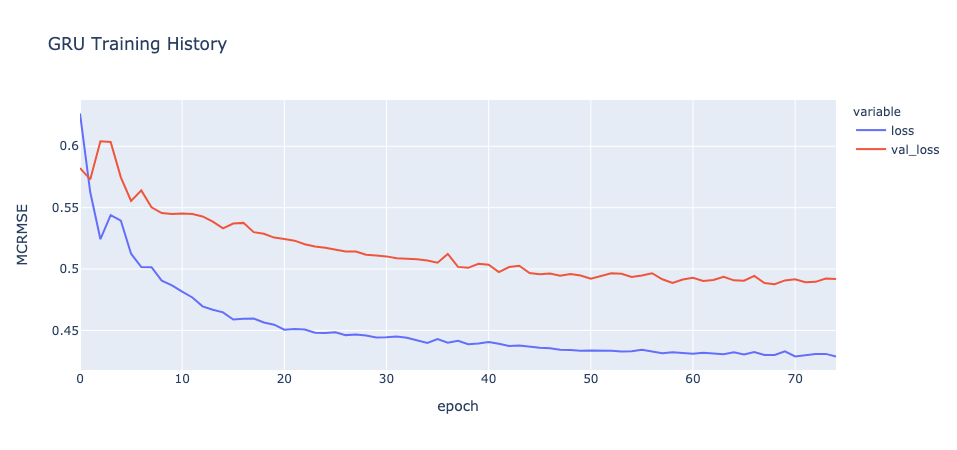

In [47]:
import plotly.express as px

fig_gru = px.line(
    history_gru.history, 
    y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='GRU Training History'
)
fig_gru.show()


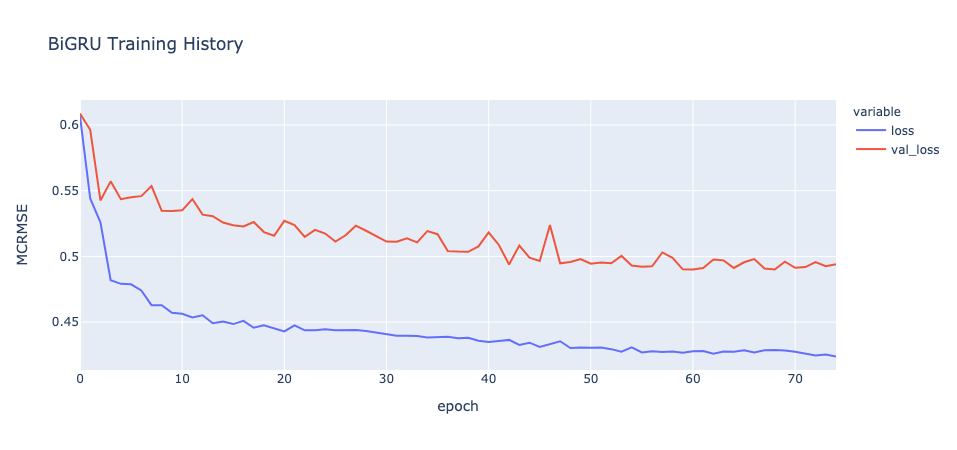

In [51]:
fig_bi_gru = px.line(
    history_bi_gru.history, 
    y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='BiGRU Training History'
)
fig_bi_gru.show()

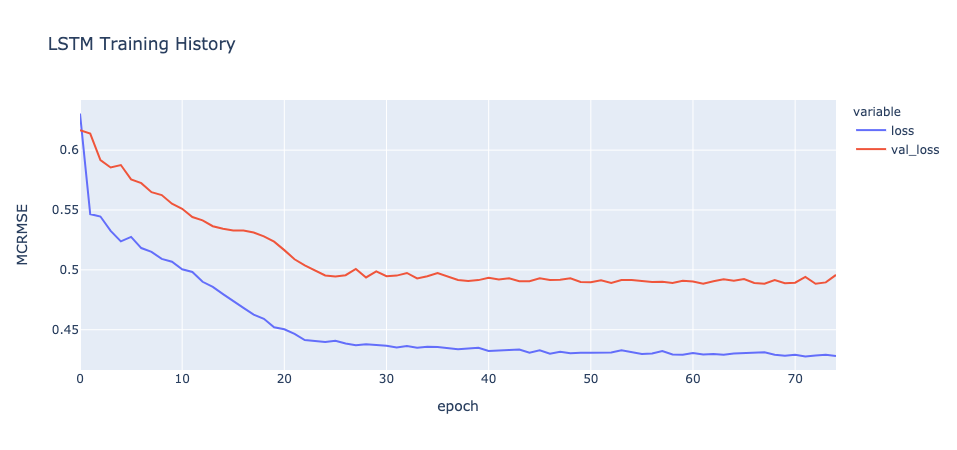

In [52]:
fig_lstm = px.line(
    history_lstm.history, 
    y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='LSTM Training History'
)
fig_lstm.show()

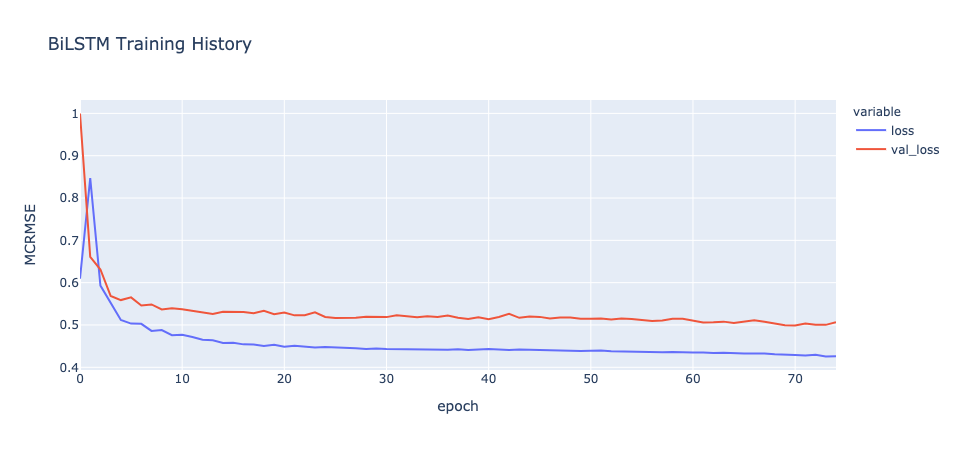

In [53]:
fig_bi_lstm = px.line(
    history_bi_lstm.history, 
    y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='BiLSTM Training History'
)
fig_bi_lstm.show()